In [1]:
from scipy.stats import bernoulli, norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats

import zipline as zp
from zipline import TradingAlgorithm
from zipline.api import order_target, record, symbol, history, add_history 

import pytz
from datetime import datetime

import random
%matplotlib inline

import pymc as pm


/Users/sy/Dropbox/FinEng/Jupyter/jup1/lib/python2.7/site-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


## Edge Analysis: Bayesian/ML Approach

The goal is to consider Edge in the language of Bayesian probability.  Say we want to  measure the quality of an entry signal $A$ using its probability of success, called $P(A)$. For example $P(A)=0.9$ means entry signal is much better than when $P(A)=0.1$. There is $90\%$ chance of success versus $10\%$.  It sounds obvious enough but to understand what 'chance of success' means in probability theory, we need to distinguish frequentist vs bayesian view of probabilty.

### Bayesian vs Frequetist

In frequentist view, $P(A) = 0.9$ means if we enter the trade, it will be successful in 9 out of 10 times. Though we are quite accustomed to this frquentist notion of probability, it is a very abtract concept in many situations. Indeed we can make one identical  trade only once. Any successive trades will not be the same since conditions change. When we say '9 out of 10 times', it means one might be real experiment but other 9 entries are 'alternative relaities' that only exist in our imagination.  

In bayesian view, $P(A) = 0.9$ simply expresses how strong our 'beliefs' are. It does not mean we are simulating trades in our mind tallying imaginary successes and failures. Quite often, this bayesian approach is more natural as it seems to coincide with human thought process.   Therefore we want to descirbe egde quailty in baysien context to see what benefit it may entail. 

### Bayesian Inference

Note that depending on context, we use terms 'belief,' 'knoweledge,' 'liekelihood', 'evidence' interchangably to refer to bayesian probability $P( )$.

#### Bayes' Theorem

Bayes' theorem is an important tool in both frequentist and bayesian probabilty theory. 
$$ P(A \mid X) = \frac{P(A) P(X \mid A)}{ P(X)} $$

In bayesian interpretation of probability, we can interprete bayes' theorem in the following ituitive way: 
$$ \text{Posterior} = \frac{\text{Prior} \times \text{Likelihood}}{\text{Evidence}} $$

To see how Bayes' theorem can be useful, we want to consider the following famous example:

#### Example 1 [Bayesian Inference]

Prior $P(A)$ : our belief that the program has no error.  Set $P(A) = p \in [0,1]$

Evidence $X$ and  probability of passing test, $P(X)$ : 
$$ P(X) = P(X \mid A) + P(X \mid \neg A) $$
$$ \text{probability of passing test } = \text{probability of passing test given there is no error} + 
\text{probability of passing test given there are errors} $$ 

Likelihood $P(X \mid A)$ : if there is no error, the test certainly passes so $P(X \mid A)=1$

To compute $P(X)$, we choose $P(X \mid \neg A) =0.5$ that is, there is $50\%$ chance of passing the test even if there are errors in the programm. Finally putting things together we have Posterior
$$ P(A \mid X) = \frac{1 \cdot p}{1 \cdot p + 0.5(1-p)} $$

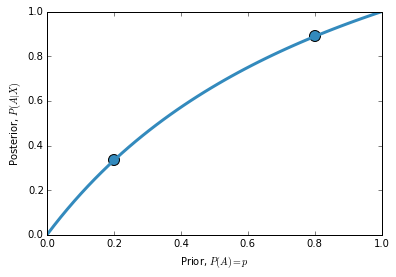

In [11]:
p = np.linspace(0, 1, 50)
plt.plot(p, p / (p + 0.5*(1-p)), lw=3, c="#338ABD")

plt.scatter(0.2, (0.2) / (0.2 + 0.5*0.8), s=120, c="#338ABD")
plt.scatter(0.8, (0.8) / (0.8 + 0.5*0.2), s=120, c="#338ABD")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Prior, $P(A) = p$")
plt.ylabel("Posterior, $P(A|X)$")


Many inferences can be made about our knowedge update after the test. For example, observe that when our prior belife was low (say around 0.2), passing test improves our belief of error free program more than when our prior belief was high enough (say around 0.8) already.

### First Tool from Bayesian ML: Naive Bayes Classifier 

#### Example [Naive Bayes Analysis of Edge]

We test an edge that drives an entry signal in a market. We denote our belief in the edge by $P(A)$, this is our prior.  For example, $P(A)$ can be simply $0.5$, meaning our belief is 'half-half.' More realistically, we want $P(A)$ to be a distribution, Gaussian for example. 

Key to Bayesian approach is we update our prior belief $P(A)$ from data, $\vec{X}$. Let $\vec{X} = \{ PL, V \}$ for this example. $PL$ is PnL resulting from the trade entry, and $V$ represents market volatility at the time of entry.
We use vector notation for $\vec{X}$ since there are multiple metrics in data.
We denote the evidence of $X$ by $P(\vec{X})$.  

Posterior, the updated knoweldge of the edge, is denoted by $P(A \mid \vec{X})$.

For likelihood, we need to decide $P(\vec{X} \mid A) = P(PL, V \mid A)$, our belief about likely data $\vec{X}$ given the edge. Now this example is 'Naive' bayes since we assume this conditional probability is independent, that is:
$$ P(\vec{X} \mid A) = P(PL, V \mid A) = P(PL \mid A) P(V \mid A) $$

Finally putting all things together:

$$ \text{Posterior} = P(A \mid \vec{X}) = \frac{P(A) P(\vec{X} \mid A)}{ P(\vec{X})}= \frac{P(A) P(PL \mid A) P(V \mid A)}{ P(\vec{X})} $$

The success of Naive Bayes will depend on how we formulate the problem and how we assign each probabilities.
For example, what should be $P(PL \mid A)$: likely PnL given our belief of the edge? We may have been just lucky even though the edge was a mistake. Sometimes we can compute $P(X)$, but more importantly we have:
$$ \text{Posterior} = P(A \mid \vec{X}) \propto P(A) P(\vec{X} \mid A) $$

#### Use sklearn scikit ML library

We can use sklearn library for a straight forward formulation of above example.

For data $\vec{X} = \{PL, V \}$, we assume $PL$ ranges from -1.0 to 1.0 while  volatility $V$ ranges from 0 to 10.

In [95]:
train_data_size = 90

PL = np.random.uniform(-100.0, 100.0, train_data_size)
V = np.random.uniform(0.0, 10.0, train_data_size)

X = np.array(zip(PL, V))


We rate edge $A$ from 1 to 6. In practice, the rating should be based on observation only. But for this demonstration we generate training data set by defining rate_edge function.  

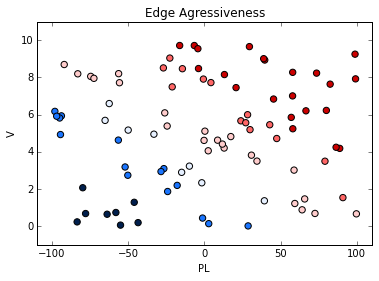

In [97]:
A = range(train_data_size)

# we rate edge arbitrary for this demonstatration.  In practice, it should based on our observation.
for i in range(train_data_size):
    A[i] = rate_edge(PL[i], V[i])
    
shades = ["#001f4d", "#1a75ff", "#e6f0ff", "#ffcccc", "#ff6666", "#cc0000"]
colors = [shades[A[bean]] for bean in range(train_data_size) ]

plt.scatter(X[:,0], X[:,1], c=colors, s=40)
plt.xlim(-110, 110)
plt.ylim(-1, 11)
plt.xlabel("PL")
plt.ylabel("V")
plt.title("Edge Agressiveness")

def rate_edge(p,v):
    if v<-0.05*p:
        agressive = 0
    elif (v > -0.05*p) and (v < -0.05*p+2.0):
        agressive = 1
    elif (v > -0.05*p+2.0) and (v < -0.05*p+4.0):
        agressive = 2
    elif (v > -0.05*p+4.0) and (v < -0.05*p+6.0):
        agressive = 3
    elif (v > -0.05*p+6.0) and (v < -0.05*p+8.0):
        agressive = 4
    else:
        agressive = 5
        
    return agressive

In [85]:
from sklearn.naive_bayes import GaussianNB

Use sklearn library to learn from training data $(\vec{X}, A)$. For this example, we use Gaussian distribution to compute likelihood. From this training data, we gain updated porsterior probability of $P(A)$.

In [98]:
clf = GaussianNB()
clf.fit(X,A)

GaussianNB()

Now we can test new data:

Edge agressiveness : [5]


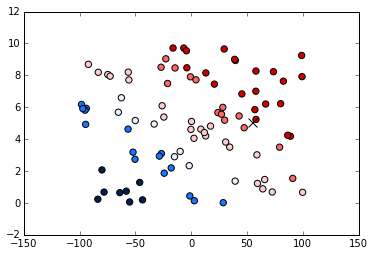

In [99]:
test_data = [55, 5]

print "Edge agressiveness :", (clf.predict([test_data]))
plt.scatter(X[:,0], X[:,1], c=colors, s=40)
plt.scatter(test_data[0], test_data[1], s=80, c="#000000", marker='x')